In [1]:
import os
os.environ['PYTHONPATH'] = "/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader6"
!pip install nibabel
!pip  install --extra-index-url https://download.pytorch.org/whl/cu117 torch==2.0.0 torchvision==0.15.0 omegaconf torchmetrics==0.10.3 fvcore iopath 
#!pip  install --extra-index-url https://download.pytorch.org/whl/cu117 torch==2.0.0 torchvision==0.15.0 omegaconf torchmetrics==0.10.3 fvcore iopath xformers==0.0.18 submitit

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [2]:
#xformers should not be installed!!!!!!!
!pip uninstall xformers -y

Found existing installation: xformers 0.0.18
Uninstalling xformers-0.0.18:
  Successfully uninstalled xformers-0.0.18


In [3]:
import torch
from functools import partial
from dinov2.models.vision_transformer import vit_base, DinoVisionTransformer
from dinov2.layers import Mlp, PatchEmbed, SwiGLUFFNFused, MemEffAttention, NestedTensorBlock as Block
# Initialize ViT-Base model with patch size 16 and any additional parameters

import torch
from dinov2.models.vision_transformer import vit_base
from dinov2.models.vision_transformer import DinoVisionTransformer

import numpy as np
    
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

ModuleNotFoundError: No module named 'dinov2'

1. The Teacher Model Includes Both backbone and dino_head: The presence of backbone and dino_head keys in the checkpoint means that the model’s head and backbone components are saved separately. You might need to handle each part separately when loading weights.

2. Mixed Precision Settings: If the checkpoint was trained with mixed precision, ensure your model and environment support loading fp16 weights. This might involve setting up a mixed-precision environment with torch.cuda.amp.

3. Specific Layers: The configuration specifies various heads (e.g., dino_head, ibot_head). If your model does not have these components, remove the related keys from the state dictionary or update your model definition to include them.

In [5]:

checkpoint_path = '/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader6/output_dir/448_192_B1and2_B8/eval/training_112499/teacher_checkpoint.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(checkpoint_path, map_location=device)
print(checkpoint.keys())
teacher_weights = checkpoint["teacher"]
teacher_weights_cleaned = {k.replace("backbone.", ""): v for k, v in teacher_weights.items()}
# Assuming you have imported vit_base and are creating a model instance
model_ct = DinoVisionTransformer(
        img_size=448,
        patch_size=16,
        drop_path_rate=0.0,
        block_chunks=1,
        drop_path_uniform=True,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4,
        block_fn=partial(Block, attn_class=MemEffAttention),
        num_register_tokens=5,
        init_values = 1.0e-05,
    ).to(device)

model_ct.load_state_dict(teacher_weights_cleaned, strict=False)
model_ct.eval()

FileNotFoundError: [Errno 2] No such file or directory: '/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader6/output_dir/448_192_B1and2_B8/eval/training_112499/teacher_checkpoint.pth'

In [7]:
#model_ct.blocks[-1][-1].attn

# Model Summary

In [8]:
# #!pip install torchinfo
# from torchinfo import summary
# model = model_ct # Replace this with your model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# summary(
#     model_ct, 
#     input_size=(1, 3, 448, 448),  # Batch size of 1, change according to your input shape
#     col_names=["input_size", "output_size", "num_params", "kernel_size"],
#     depth=5  # Controls the level of depth to display in nested modules
# )

(525, 525, 3)
input_array_temp.shape (525, 525, 3)
torch.Size([1, 3, 448, 448])
torch.Size([1, 3, 448, 448]) torch.Size([1, 3, 448, 448])
torch.Size([1, 12, 790, 790])
After mean over heads: torch.Size([1, 790, 790])
After slicing: torch.Size([784, 784])
0.00089656375 0.0034394031


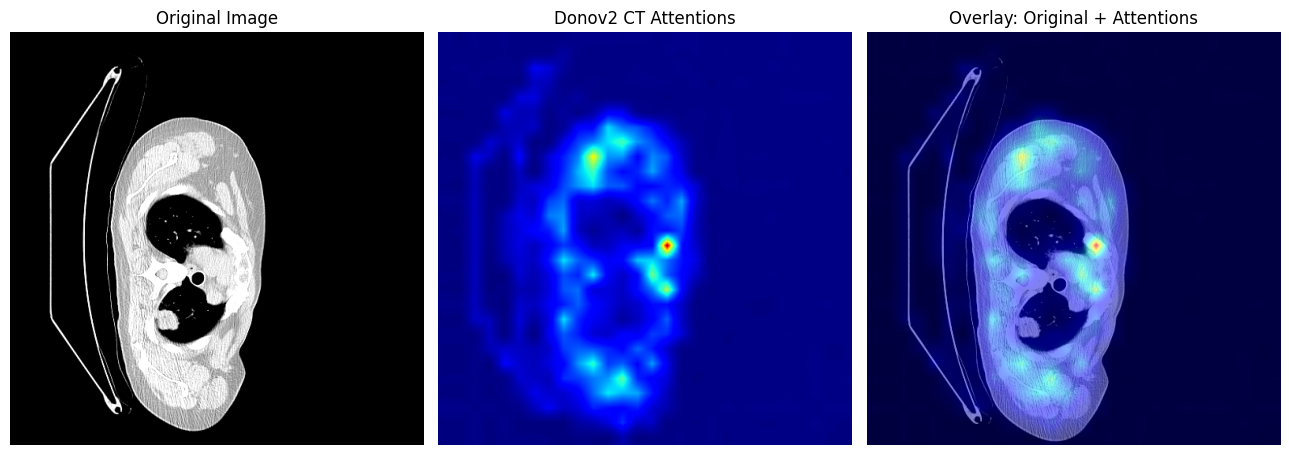

In [9]:
import nibabel as nib
# Load NIfTI image and extract a slice
nii_image = nib.load("2.nii").get_fdata()
image_slice = nii_image[:, :, 176:179]  # Extract slices (175th to 177th, 0-indexed)
#image_slice = nii_image[:, :, 180:183]  # Extract slices (175th to 177th, 0-indexed)

# nii_image = nib.load("1.nii.gz").get_fdata()
# image_slice = nii_image[:, :, 100:103]  # Extract slices (175th to 177th, 0-indexed)

# nii_image = nib.load("3.nii").get_fdata()
# image_slice = nii_image[:, :, 232:235]  # Extract slices (175th to 177th, 0-indexed)
vmin, vmax, eps = -500., 100., 0.00005
image_slice = np.array(image_slice, dtype=np.float32)
image_slice = np.clip(image_slice, vmin, vmax )
image_slice = np.clip((image_slice - vmin) / (vmax-vmin), eps, 1-eps)
input_tensor = image_slice.astype(np.float32)
# print(input_tensor.min(),input_tensor.max())
# plt.imshow(input_tensor[:,:,1], cmap="grey")
# plt.show()
print(input_tensor.shape)
eps = 0.000001
input_array_temp  = np.clip(input_tensor, eps, 1-eps)
# print(input_tensor.min(),input_tensor.max())
# plt.imshow(input_array3[:,:,1], cmap="grey")
# plt.show()
print("input_array_temp.shape",input_array_temp.shape)
w, h = 512, 512
# Convert to (C, H, W)
input_array = np.transpose(input_array_temp, (2, 0, 1))  # (3, 512, 512)

# Convert to PyTorch tensor
input_tensor = torch.from_numpy(input_array)  # (3, 512, 512)

# Resize using interpolate
input_tensor = F.interpolate(
    input_tensor.unsqueeze(0),  # (1, 3, 512, 512)
    size=(448, 448),
    mode='bilinear',
    align_corners=False
).squeeze(0)  # (3, 448, 448)

# Normalize
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)  # (3, 1, 1)
std = torch.tensor([0.2, 0.2, 0.2]).view(3, 1, 1)   # (3, 1, 1)

input_tensor = (input_tensor - mean) / std  # Broadcasting works now
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.to(torch.float32)
print(input_tensor.shape)  # (1, 3, 448, 448)
##########################################################################################################
def get_attention_map(model, x):
    attention_maps = []
    def hook(module, input, output):
        attention_maps.append(output)
    hook_handle = model_ct.blocks[-1][-1].attn.attn_drop.register_forward_hook(hook)
    print(x.shape, x.shape)
    _ = model(x)
    hook_handle.remove()
    return attention_maps[0]
##########################################################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Get the attention map from the model's last attention layer
with torch.no_grad():
    attn_map = get_attention_map(model_ct, input_tensor.to(device))#input_tensor 1 3 448 448
    print(attn_map.shape)  # Expect torch.Size([1, 12, 790, 790])   
    attn_map = attn_map.mean(dim=1)  # Average over all heads   [1, 790, 790]
    print("After mean over heads:", attn_map.shape)
    attn_map = attn_map[0, 6:, 6:]  # Simplified to handle square grids
    print("After slicing:", attn_map.shape)
    attn_map = attn_map.mean(dim=0).reshape(28, 28) #this line?
attn_map_resized = F.interpolate(attn_map.unsqueeze(0).unsqueeze(0), size=(h, w), mode='bilinear').squeeze()

############################### ############################### ##############################
############################### ############################### ##############################

fig, axes = plt.subplots(1, 3, figsize=(13, 8))

#image1 = np.asarray(original_image)
image2 = attn_map_resized.cpu().numpy()  # Replace with actual data



axes[ 0].imshow(input_array_temp[:,:,1], vmin=0.0, vmax=0.99, cmap="grey")
axes[0].set_title('Original Image')
axes[ 0].axis('off')

axes[ 1].imshow(image2**3,  cmap='jet')
axes[ 1].set_title('Donov2 CT Attentions')
axes[ 1].axis('off')
print(image2.min(),image2.max())

# Overlay Attention Map on Original Image
axes[2].imshow(input_array_temp[:, :, 1], cmap='gray')  # Base image in grayscale
axes[2].imshow(image2**3, cmap='jet', alpha=0.5)  # Attention map overlay
axes[2].set_title('Overlay: Original + Attentions')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [10]:
#model_ct

In [11]:
# #!pip install torchinfo
# from torchinfo import summary
# model = model_ct # Replace this with your model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# summary(
#     model_ct, 
#     input_size=(1, 3, 448, 448),  # Batch size of 1, change according to your input shape
#     col_names=["input_size", "output_size", "num_params", "kernel_size"],
#     depth=5  # Controls the level of depth to display in nested modules
# )

In [12]:
# def get_cls_attention_map(model, x):
#     attention_maps = []

#     def hook(module, input, output):
#         attention_maps.append(output)

#     handle = model.blocks[-1][-1].attn.attn_drop.register_forward_hook(hook)
#     _ = model(x)
#     handle.remove()
#     return attention_maps[0]  # [1, 12, 790, 790]

# cls_attention_map = get_cls_attention_map(model_ct, input_tensor.to(device))
# print(cls_attention_map[:, :, 0, :].shape)  # Attention to CLS token
